In [29]:
from abc import abstractmethod, ABC
from typing import Callable, Tuple, List, Optional
from IPython.core.display_functions import display
from sklearn.datasets import make_classification, make_moons
from sklearn import datasets
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier, Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score, f1_score, balanced_accuracy_score
from time import time_ns, time
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
plt.rcParams["figure.figsize"] = (20,10)
random_state = 244827
n_samples = 2427
n_trains = 1

In [53]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True, stratify=gen[1])

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            if self.x_train[:, i].dtype not in [int, float]:
                continue

            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v
            else:
                self.x_train[:, i] = 1
                self.x_test[:, i] = 1
        return self

    def transpose_data(self):
        self.x_train = self.x_train.T
        self.x_test = self.x_test.T
        return self

    def change_labels(self, old: list, new: list):
        for o, n in zip(old, new):
            self.y_test[self.y_test == o] = n
            self.y_train[self.y_train == o] = n
        return self

    def winsorize(self):
        for i in range(self.x_train.shape[1]):
            if self.x_train[:, i].dtype not in [int, float] or len(np.unique(self.x_train[:, i])) == 2:
                continue
            q1_train = np.percentile(self.x_train[:, i], 25)
            q3_train = np.percentile(self.x_train[:, i], 75)
            iqr_train = q3_train - q1_train
            self.x_train[:, i] = np.clip(self.x_train[:, i], q1_train - 1.5 * iqr_train, q3_train + 1.5 * iqr_train)

            q1_test = np.percentile(self.x_test[:, i], 25)
            q3_test = np.percentile(self.x_test[:, i], 75)
            iqr_test = q3_test - q1_test
            self.x_test[:, i] = np.clip(self.x_test[:, i], q1_test - 1.5 * iqr_test, q3_test + 1.5 * iqr_test)
        return self

    def make_polynomial(self, poly_degree=2, include_bias=False):
        self.x_test = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_test)
        self.x_train = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_train)
        return self

In [3]:
class ActivationFunction(ABC):
    threshold = 0

    @abstractmethod
    def __call__(self, x: ndarray) -> ndarray:
        raise NotImplementedError

    @abstractmethod
    def derivative(self, x: ndarray) -> ndarray:
        raise NotImplementedError

    def d(self, x: ndarray) -> ndarray:
        return self.derivative(x)

class Heaviside(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return np.where(x >= 0, 1, 0)

    def derivative(self, x: ndarray) -> ndarray:
        return np.ones_like(x)

class Sin(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return np.sin(x)

    def derivative(self, x: ndarray) -> ndarray:
        return np.cos(x)

class Tanh(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return np.tanh(x)

    def derivative(self, x: ndarray) -> ndarray:
        return 1 / (np.cosh(x) ** 2)

class Sign(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return np.sign(x)

    def derivative(self, x: ndarray) -> ndarray:
        return np.ones_like(x)

class Relu(ActivationFunction):
    def __call__(self, x: ndarray) -> ndarray:
        return np.where(x >= 0, x, 0)

    def derivative(self, x: ndarray) -> ndarray:
        return np.where(x >= 0, 1, 0)

class LeakyRelu(ActivationFunction):
    threshold = 0.01

    def __call__(self, x: ndarray) -> ndarray:
        return np.where(x >= 0, x, 0.01 * x)

    def derivative(self, x: ndarray) -> ndarray:
        return np.where(x >= 0, 1, 0.01)

class Sigmoid(ActivationFunction):
    threshold = 0.5

    def __call__(self, x: ndarray) -> ndarray:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: ndarray) -> ndarray:
        return self(x) * (1 - self(x))

In [118]:
def expand_features(X: ndarray) -> ndarray:
        return np.c_[np.ones(X.shape[0]) * -1, X]


class DenseLayer:
    _accepted_activation_functions = ['Heaviside', 'sin', 'tanh', 'sign', 'Relu', 'LeakyRelu', 'sigmoid']
    def __init__(self, input_features: int, n_neurons: int, activation: str):
        self.n_neurons = n_neurons
        self.input_features = input_features
        self.activation: ActivationFunction = {'Heaviside': Heaviside(),
                           'sin': Sin(),
                           'tanh': Tanh(),
                           'sign': Sign(),
                           'Relu': Relu(),
                           'LeakyRelu': LeakyRelu(),
                           'sigmoid': Sigmoid()}[activation]

        self.estimators: ndarray = np.random.normal(loc=1, scale=.15, size=(n_neurons, input_features))

    def forward(self, X: ndarray) -> ndarray:
        return X.dot(self.estimators.T)

    def activate(self, S: ndarray) -> ndarray:
        return self.activation(S)

    def predict(self, X: ndarray) -> ndarray:
        return self.activate(X.dot(self.estimators.T))

class NeuralNetwork:
    def __init__(self, layers: List[int], learning_rate: float = 0.01, min_lr: float=0.001, max_lr=0.01, batch_size=64, max_epochs=1000, verbose=False, dynamic_lr=False):
        self.learning_rate = learning_rate
        self.min_learning_rate = min_lr
        self.max_learning_rate = max_lr
        self.batch_size = batch_size
        self.verbose = verbose
        self.dynamic_lr = dynamic_lr
        self.epochs = max_epochs
        self.n_layers = len(layers)
        self.activation = Sigmoid()
        self.coefs_ = [np.random.randn(layers[i], layers[i - 1]) * np.sqrt(1 / layers[i - 1]) for i in range(1, self.n_layers)]
        self.intercepts = [np.random.rand(i, 1) for i in layers[1:]]

    def _forward(self, X: ndarray) -> Tuple[ndarray, ndarray, ndarray]:
        pre = []
        activated = []
        for w, b in zip(self.coefs_, self.intercepts):
            z = w.dot(X) + b
            X = self.activation(z)
            pre.append(z)
            activated.append(X)

        return X, pre, activated

    def _deltas(self, pre_activated: ndarray, Y: ndarray, predicted: ndarray):
        d_loss = self._derivative_loss_function(Y, predicted) * self.activation.d(pre_activated[-1])
        deltas = [0] * (self.n_layers - 1)
        deltas[-1] = d_loss
        for l in range(len(deltas)-2, -1, -1):
            delta = self.coefs_[l+1].T.dot(deltas[l+1]) * self.activation.d(pre_activated[l])
            deltas[l] = delta
        return deltas

    def _backward(self, deltas, activated_outputs):
        d_coefs = []
        d_intercepts = []
        deltas = [0] + deltas
        for layer_index in range(1, self.n_layers):
            dW_l = deltas[layer_index].dot(activated_outputs[layer_index - 1].T)
            db_l = deltas[layer_index]
            d_coefs.append(dW_l)
            d_intercepts.append(np.expand_dims(db_l.mean(axis=1), 1))
        return d_coefs, d_intercepts


    def fit(self, X, Y, epochs=1000, verbose=False):
        self.verbose = verbose
        self.epochs = epochs
        Y = Y.reshape(-1, 1).T
        n = X.shape[1]
        batch_divisible = n - n % self.batch_size

        for e in tqdm(range(self.epochs), disable=not self.verbose):
            indexes = np.arange(0, n, 1)
            np.random.shuffle(indexes)
            batched_X = X[:, indexes]
            batched_Y = Y[:, indexes]

            tab = np.array([1]).reshape(-1, 1)

            batched_X = batched_X[:, :batch_divisible]
            batched_Y = batched_Y[:, :batch_divisible]

            for i in tqdm(range(0, batch_divisible, self.batch_size), desc=f'Batches for {e} epoch'):
                X_batch = batched_X[:, i:i + self.batch_size]
                Y_batch = batched_Y[:, i:i + self.batch_size]

                preds, pre_activated, activate_outputs = self._forward(X_batch)
                deltas = self._deltas(pre_activated=pre_activated, Y=Y_batch, predicted=preds)
                dW, db = self._backward(deltas=deltas, activated_outputs=activate_outputs)

                for layer_index in range(self.n_layers):
                    self.coefs_[layer_index] = self.coefs_[layer_index] - self.learning_rate * dW[layer_index] / self.batch_size
                    self.intercepts[layer_index] = self.intercepts[layer_index] - self.learning_rate * db[layer_index] / self.batch_size

            if self.dynamic_lr:
                self.learning_rate = self.min_learning_rate + (self.max_learning_rate - self.min_learning_rate) * (
                            1 + np.cos(e / self.epochs * np.pi))

        return self

    def decision_function(self, X: ndarray) -> ndarray:
        for coef, intercept in zip(self.coefs_, self.intercepts):
            z = np.dot(coef, X) + intercept
            X = self.activation(z)
        return X

    def predict(self, X: ndarray) -> ndarray:
        return np.where(self.decision_function(X) > 0.5, 1, 0).reshape(X.shape[1], )

    @staticmethod
    def _loss_function(true: ndarray, predicted: ndarray) -> ndarray:
        n = predicted.shape[1]
        cost = (1. / (2 * n)) * np.sum((true - predicted) ** 2)
        return cost

    @staticmethod
    def _derivative_loss_function(true: ndarray, predicted: ndarray) -> ndarray:
        return predicted - true


linear_data = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=2,
                        random_state=random_state), random_state=random_state).transpose_data()
data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)).transpose_data()

model = NeuralNetwork([2, 128, 1], batch_size=64)
model.fit(linear_data.x_train, linear_data.y_train, epochs=2000, verbose=True)

  0%|          | 0/2000 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (128,2) (128,128) 

In [61]:
def display_neural_network(model: NeuralNetwork, data: PUMData):
    f, ax = plt.subplots(1, 3, tight_layout=True, figsize=(20, 10))

    x_min, x_max = data.x_test[0, :].min() - 0.25, data.x_test[0, :].max() + 0.25
    y_min, y_max = data.x_test[1, :].min() - 0.25, data.x_test[1, :].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(mesh_data.T).reshape(xx.shape)

    ax[0].contourf(xx, yy, Z, alpha=0.4, levels=1)
    ax[0].scatter(data.x_test[0, :], data.x_test[1, :], c=data.y_test, s=20, edgecolor="k")
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(y_min, y_max)

    predictions = model.predict(data.x_test)
    cm = confusion_matrix(data.y_test, predictions, labels=[0, 1])
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specifity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    sns.heatmap(cm, annot=True, fmt="d", ax=ax[1], cmap="Blues")
    ax[1].set_title(f'Czulość: {sensitivity}, swoistość: {specifity}, Adjusted accuracy={balanced_accuracy_score(data.y_test, predictions, adjusted=True)}')

    decision_function = model.decision_function(data.x_test)
    fpr, tpr, thresholds = roc_curve(data.y_test, decision_function)
    ax[2].plot(fpr, tpr, label=f'Model AUC={roc_auc_score(data.y_test, decision_function):.3f}')
    ax[2].plot([0, 1], [0, 1], 'k--')
    ax[2].set_xlabel('FPR')
    ax[2].set_ylabel('TPR')
    ax[2].set_title('ROC')
    ax[2].legend()
    plt.show()

    return balanced_accuracy_score(data.y_test, predictions, adjusted=True)

In [103]:
linear_data = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=2, random_state=random_state), random_state=random_state).transpose_data()
data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)).transpose_data()

In [104]:
model = NeuralNetwork([2, 128, 128, 128, 1], batch_size=2)
model.fit(linear_data.x_train, linear_data.y_train, epochs=2000, verbose=True)

  0%|          | 0/2000 [00:00<?, ?it/s]


IndexError: index 2 is out of bounds for axis 1 with size 2

ValueError: Found input variables with inconsistent numbers of samples: [486, 1]

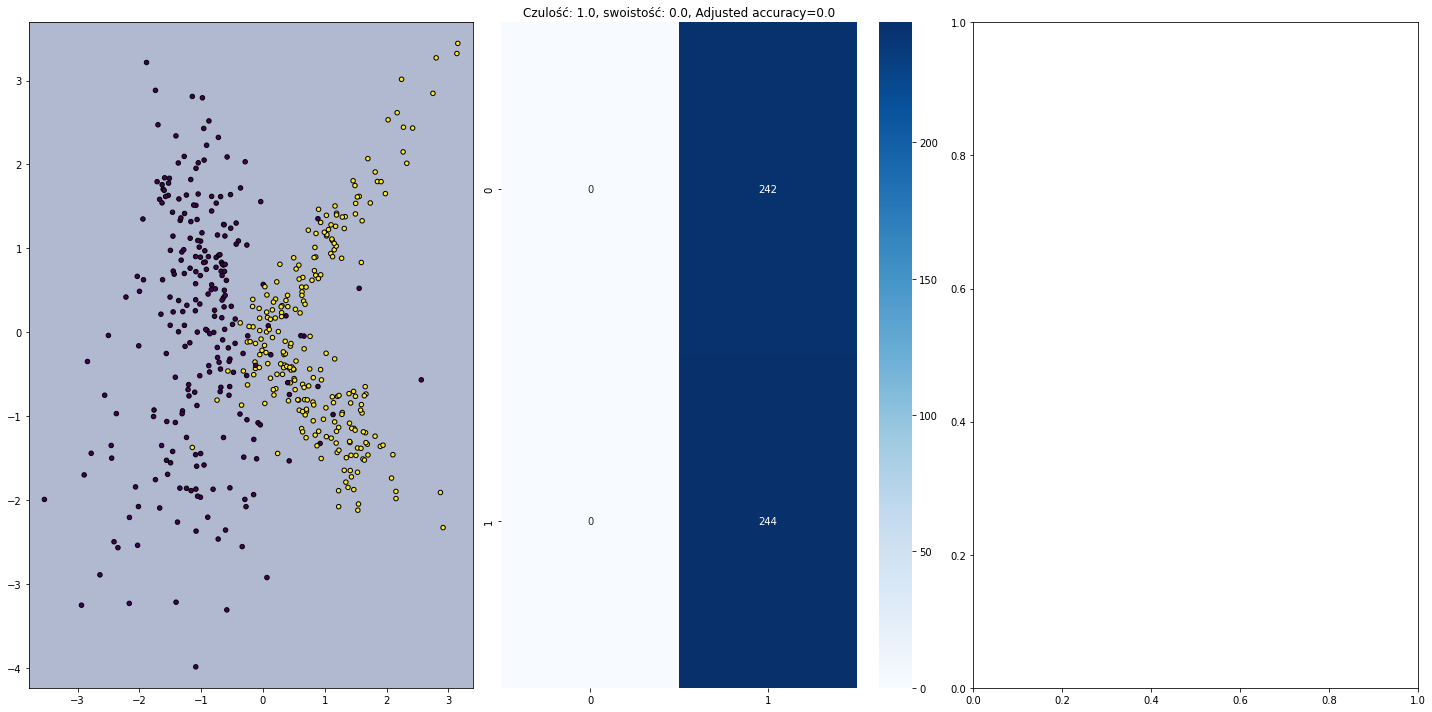

In [100]:
display_neural_network(model, linear_data)
